In [5]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

### Description of the code

Numerical solution to lava flowing down a plane using the implicit method.
This code also compares the analytic solution found in class (where steady state was assumed) to that implicit computation not assuming steady state.

Below, you will also find the code for Q2. Though the figures have been included in their place in the submission.

#### Name: Maude Larivière (260925122)
Collaborator: Ana Hoban, Amalia Karalis

Date: March 8th 2022

## Q3

Momentum equation: 
$$ \frac{D}{Dt}\vec{u} = \frac{1}{\rho}\vec{\nabla}P + \nu\vec{\nabla}^2\vec{u} + \frac{1}{\rho}\vec{f_g} $$

Hydrostatic equilibrium in y direction, so we only have $\vec{u}=u(y)\hat{x}$. So we only look at x-direction, where there is no pressure gradient and because u(y), the $(\vec{u} \cdot \vec{\nabla})\vec{u}$ term goes to 0.

We thus have the following equation:
$$\partial _t \vec{u} = \nu\vec{\nabla}^2\vec{u} + \frac{1}{\rho}\vec{f_g}$$

Now, we just need to reduce this with what we know (i.e. gravity and the fact that u is a function of only y in the x-direction):
$$\partial _t \vec{u} = \nu \partial ^2 _y u + g\sin \alpha$$
where $\alpha$ is the inclination of the plane.

This takes the form $\partial _t f = D \nabla ^2 f + R$, where $R$ is a constant. This ressemble the exercice we coded with the diffusion term of the advection velocity, with a constant added.

We can thus do the same process -- and add the constant afterwards.

Or since our system is $Ax^{n+1} + R = x^{n}$, we can rewrite it as $Ax^{n+1} = x^{n}-R$ and we just have to be careful what we input in linalg.solve().

<IPython.core.display.Javascript object>


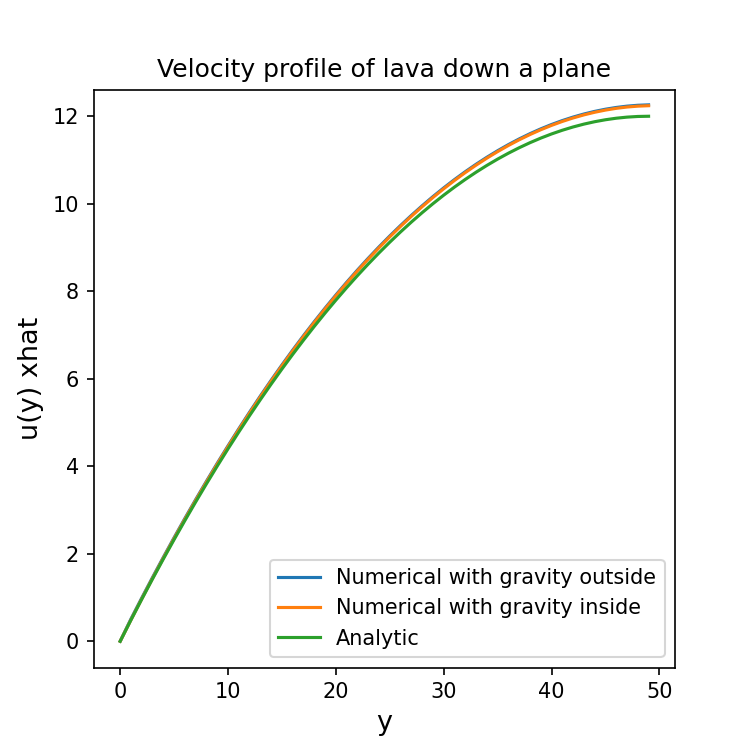

In [3]:
# Start by initializing the basics of this problem!

### TIME
dt = 2 # time jump
nSteps = 4000 # number of steps

### SPACE
# This means n points, spaced by dy on a grid of side length n/y_tot #
dy = 1 # space jump
n = 50 # number of points in the space grid
y = np.arange(0, n*1., dy) # set the grid
size, = y.shape
# NOTE: in this case, the height of the lava column, denoted by y, will be our x-axis

### CONSTANTS
H = max(y) # height of the lava column's interface with air
g = 0.01 # set to a scale that fits the other params
nu = 1 # diffusion coefficient

# Gravity constant term
gravity = np.ones(size)*g
gravity[0] = 0 # This is needed to match the analytical solution (which has no-slip inforced)
                # It's not physical, but otherwise it'll drift off the screen

# Diffusion term
beta = nu*dt/dy**2

### SOLUTIONS
# Analytic
uAnal = -g * (y**2/2 - H*y) / nu

# Numerical
uNum_gravOutside = np.zeros(size) # This one is for the general solving method, i.e. solve diffusion and add gravity after
uNum_gravInside = np.zeros(size)  # This one is an attempt at seeing if including the gravity in the linalg solving works

# Tri-diag matrix representing the dynamics of the system, as defined in class
A = np.eye(size)*(1.0+2.0*beta) + np.eye(size, k=1)*-beta + np.eye(size,k=-1)*-beta

# No-slip BC
A[0:1,:] = np.zeros(size)
A[0,0] = 1

# No stress BC
A[size-1,size-1] = 1+beta

### PLOT
fig, ax = plt.subplots(1,1,figsize=(5,5))
plt.ylabel('u(y) xhat',fontsize=13)
plt.xlabel('y',fontsize=13)
plt.title('Velocity profile of lava down a plane')
# One plot for each solution
plot, = ax.plot(y,uNum_gravOutside,label='Numerical with gravity outside')
plot2, = ax.plot(y,uNum_gravInside,label='Numerical with gravity inside')
plot3, = ax.plot(y,uAnal,label='Analytic')

plt.legend(loc=0)

# IMPLICIT METHOD
# Implementation of the implicit method -- iteration through time and update velocity
for i in range(nSteps):
    # Implicit method for diffusion -- adding gravity after -- the expected method
    uNum_gravOutside = np.linalg.solve(A,uNum_gravOutside)
    uNum_gravOutside += gravity*dt # gravity * dt for units to work
    
    # Implicit method considering x^n+gravity = Ax^n+1n-- the one we're not sure if it works
    uNum_gravInside = np.linalg.solve(A,uNum_gravInside + gravity*dt)
    
    # Clearing out numerical solutions at previous step and plotting the updated solution
    ax.collections = []
    ax.patches = []
    plot.set_ydata(uNum_gravOutside)
    plot2.set_ydata(uNum_gravInside)
    
    fig.canvas.draw()
    plt.pause(0.01)

## Q2

### b)


<IPython.core.display.Javascript object>


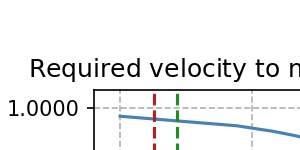

In [51]:
from scipy.optimize import fsolve

nuWater = 1e-6 # kin viscosity of water in m^2/s

def velocity(u, nu):
    return 671.4*u**2 + 253*np.sqrt(nu*u**3) - 671.25

nuArray = np.linspace(1,10**4,1500)*nuWater # array of kin viscosity -- don't start at 0, because we log later 
                                            # -- in nuWater units

expected = np.ones_like(nuArray) # Set all expected velocity at one for simplicity

vel = fsolve(velocity,expected,args=(nuArray)) # Perform the numerical solving

### List of common kin viscosity of liquid to plot -- all in nuWater units
nuHoney = 7.36e-5/nuWater 
nuBeer = 1.8e-6/nuWater
nuMolasse = 1.3e-3/nuWater
nuKerosene = 2.7e-6/nuWater
### All these values taken from: https://www.engineersedge.com/fluid_flow/kinematic-viscosity-table.htm

### Plotting
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.xlabel(r'Kinematic viscosity $\nu$ (in $\nu_{water}$ units)')
plt.ylabel(r'Velocity u $(m/s)$')
plt.title(r'Required velocity to maintain $P_{tot}=671.25W$ in various $\nu$')
plt.grid(ls='--')
plt.plot(nuArray/nuWater,vel,color='steelblue')
plt.axvline(x=nuBeer,label=r'$u_{beer}$',color='firebrick',ls='--')
plt.axvline(x=nuKerosene,label=r'$u_{kerosene}$',color='forestgreen',ls='--')
plt.axvline(x=nuHoney,label=r'$u_{honey}$',color='darkgoldenrod',ls='--')
plt.axvline(x=nuMolasse,label=r'$u_{molasse}$',color='deeppink',ls='--')
plt.legend(loc=0)
#plt.savefig('Lariviere_Fluids_Pset3_Q2.2.png',bbox_inches='tight')
plt.show()

### c)

<IPython.core.display.Javascript object>


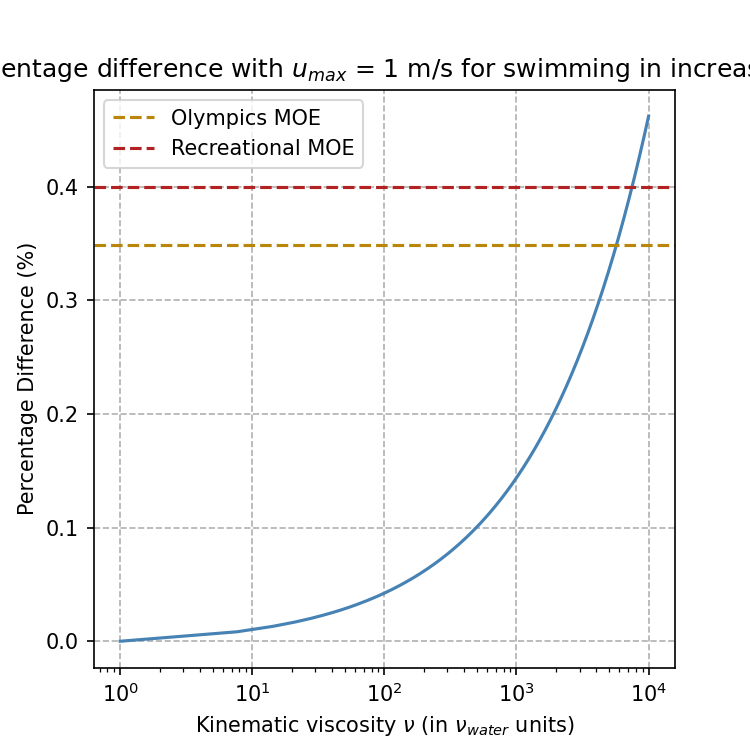

In [50]:
maxSpeed = max(vel) # get the maximal speed

percentageDiff = (np.abs(maxSpeed - vel)/(maxSpeed + vel)/2)*100 # compute the percentage difference

### OLYMPICS
# Results found for Tokyo 2021 on the official Olympics website
gold = np.array([21.07,3*60+37.58,57.47,60+53.50,3*60+51.60,7*60+40.33,3*60+56.69])
silver = np.array([21.55,3*60+38.86,57.72,60+53.92,3*60+51.73,7*60+40.73,3*60+57.36])

diffOl = silver-gold
stdDiffOl = np.std(diffOl)
###

plt.figure(figsize=(5,5))
plt.plot(nuArray/nuWater, percentageDiff, color='steelblue')
plt.ylabel(r'Percentage Difference (%)')
plt.xlabel(r'Kinematic viscosity $\nu$ (in $\nu_{water}$ units)')
plt.title(r'Percentage difference with $u_{max}$ = 1 m/s for swimming in increasing $\nu$')
plt.grid(ls='--')
plt.xscale('log')
plt.axhline(y=stdDiffOl,color='darkgoldenrod',ls='--',label='Olympics MOE')
plt.axhline(y=0.4,color='firebrick',ls='--',label='Recreational MOE') # smaller effect for recreational
plt.legend(loc=0)
#plt.savefig('Lariviere_Fluids_Pset3_Q2.3.png',bbox_inches='tight')
plt.show()